In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import gc
import random

import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings(action='ignore')

from pycaret.classification import *

import random as python_random
np.random.seed(42)
python_random.seed(42)
set_config('seed', 42)

In [2]:
PATH = './data/'

train_err  = pd.read_csv(PATH+'train_err_data.csv')
train_qua = pd.read_csv(PATH+'train_quality_data.csv')
train_prob = pd.read_csv(PATH+'train_problem_data.csv')

test_err  = pd.read_csv(PATH+'test_err_data.csv')
test_qua  = pd.read_csv(PATH+'test_quality_data.csv')

sample_submssion = pd.read_csv(PATH+'sample_submission.csv')

In [3]:
train_err

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1
2,10000,20201101030309,model_3,05.15.2138,11,1
3,10000,20201101050514,model_3,05.15.2138,16,1
4,10000,20201101050515,model_3,05.15.2138,4,0
...,...,...,...,...,...,...
16554658,24999,20201130163051,model_3,05.15.2138,15,1
16554659,24999,20201130172625,model_3,05.15.2138,16,1
16554660,24999,20201130172625,model_3,05.15.2138,4,0
16554661,24999,20201130172631,model_3,05.15.2138,4,0


In [3]:
train_err['date'] = train_err['time'].astype(str).str.slice(0,8)
train_err['model_fwver'] = train_err.model_nm + train_err.fwver
train_err['errtype_code'] = train_err.errtype.astype(str) + train_err.errcode

train_err_0 = train_err[['user_id','date','model_fwver','errtype_code']].drop_duplicates()
display(train_err_0.head())

test_err['date'] = test_err['time'].astype(str).str.slice(0,8)
test_err['model_fwver'] = test_err.model_nm + test_err.fwver
test_err['errtype_code'] = test_err.errtype.astype(str) + test_err.errcode

test_err_0 = test_err[['user_id','date','model_fwver','errtype_code']].drop_duplicates()
display(test_err_0.head())

,user_id,date,model_fwver,errtype_code
0,10000,20201101,model_305.15.2138,151
1,10000,20201101,model_305.15.2138,121
2,10000,20201101,model_305.15.2138,111
3,10000,20201101,model_305.15.2138,161
4,10000,20201101,model_305.15.2138,40


,user_id,date,model_fwver,errtype_code
0,30000,20201101,model_104.16.3553,311
1,30000,20201101,model_104.16.3553,332
2,30000,20201101,model_104.16.3553,151
3,30000,20201101,model_104.16.3553,221
4,30000,20201101,model_104.16.3553,111


In [ ]:
train_err.shape, train_err_0.shape

In [4]:
train_err_1 = train_err.groupby(['user_id','date']).count().reset_index()[['user_id','date','time']]
train_err_1.columns = ['user_id','date','date_cnt']
train_err_1 = train_err_1.groupby('user_id').agg({'date':'count','date_cnt': 'sum'}).reset_index()
train_err_1.columns = ['user_id','date_cnt', 'date_sum']
display(train_err_1.head())

test_err_1 = test_err.groupby(['user_id','date']).count().reset_index()[['user_id','date','time']]
test_err_1.columns = ['user_id','date','date_cnt']
test_err_1 = test_err_1.groupby('user_id').agg({'date':'count','date_cnt': 'sum'}).reset_index()
test_err_1.columns = ['user_id','date_cnt', 'date_sum']
display(test_err_1.head())

train_err_1.shape

,user_id,date_cnt,date_sum
0,10000,30,317
1,10001,30,2365
2,10002,29,306
3,10003,30,306
4,10004,30,777


,user_id,date_cnt,date_sum
0,30000,29,2750
1,30001,28,284
2,30002,30,941
3,30003,28,371
4,30004,30,881


(15000, 3)

In [5]:
train_err_2 = train_err.groupby('model_fwver').count().reset_index()[['model_fwver','user_id']]
train_err_2.columns = ['model_fwver','model_fwver_cnt']
train_err_2['model_fwver_rank'] = train_err_2.model_fwver_cnt.rank()
display(train_err_2.head())

test_err_2 = test_err.groupby('model_fwver').count().reset_index()[['model_fwver','user_id']]
test_err_2.columns = ['model_fwver','model_fwver_cnt']
test_err_2['model_fwver_rank'] = test_err_2.model_fwver_cnt.rank()
display(test_err_2.head())

,model_fwver,model_fwver_cnt,model_fwver_rank
0,model_004.22.1442,2522,21.0
1,model_004.22.1656,39,7.0
2,model_004.22.1666,5,1.0
3,model_004.22.1684,5554,25.0
4,model_004.22.1750,2874213,36.0


,model_fwver,model_fwver_cnt,model_fwver_rank
0,model_004.22.1170,817,18.0
1,model_004.22.1448,840,21.0
2,model_004.22.1478,535,15.0
3,model_004.22.1608,12,2.0
4,model_004.22.1656,835,19.0


In [6]:
# train_err > errtype_code => rank
train_err_3 = train_err.groupby('errtype_code').count().reset_index()[['errtype_code','user_id']]
train_err_3.columns = ['errtype_code','errtype_code_cnt']
train_err_3['errtype_code_rank'] = train_err_3.errtype_code_cnt.rank()
display(train_err_3.head())

# test_err > errtype_code => rank
test_err_3 = test_err.groupby('errtype_code').count().reset_index()[['errtype_code','user_id']]
test_err_3.columns = ['errtype_code','errtype_code_cnt']
test_err_3['errtype_code_rank'] = test_err_3.errtype_code_cnt.rank()
display(test_err_3.head())

,errtype_code,errtype_code_cnt,errtype_code_rank
0,10,21079,2825.0
1,101,133403,2851.0
2,111,307030,2854.0
3,121,320181,2855.0
4,131,22843,2828.0


,errtype_code,errtype_code_cnt,errtype_code_rank
0,10,21381,2980.0
1,101,149008,3002.0
2,111,327050,3008.0
3,121,304129,3005.0
4,131,13944,2974.0


In [10]:
# train_err > errtype_code => rank
train_err_4 = train_err.groupby(['model_fwver','errtype_code']).count().reset_index()[['model_fwver','errtype_code','user_id']]
train_err_4.columns = ['model_fwver','errtype_code','cnt']
train_err_4['rank'] = train_err_4.cnt.rank()
display(train_err_4.head())

,model_fwver,errtype_code,cnt,rank
0,model_004.22.1442,101,1,1781.5
1,model_004.22.1442,111,59,4762.5
2,model_004.22.1442,121,66,4773.0
3,model_004.22.1442,131,10,4471.5
4,model_004.22.1442,141,10,4471.5


In [11]:
# test_err > errtype_code => rank
test_err_4 = test_err.groupby(['model_fwver','errtype_code']).count().reset_index()[['model_fwver','errtype_code','user_id']]
test_err_4.columns = ['model_fwver','errtype_code','cnt']
test_err_4['rank'] = test_err_4.cnt.rank()
display(test_err_4.head())

,model_fwver,errtype_code,cnt,rank
0,model_004.22.1170,111,30,4765.0
1,model_004.22.1170,121,31,4772.0
2,model_004.22.1170,131,1,1814.0
3,model_004.22.1170,141,20,4696.5
4,model_004.22.1170,151,130,4987.0


In [15]:
train = train_err.merge(train_err_1, on=['user_id'], how='left').merge(train_err_4, on=['model_fwver','errtype_code'], how='left')#.merge(train_err_3, on='errtype_code', how='left')
train = train[['user_id','date_cnt','date_sum','model_fwver','errtype_code','cnt','rank']].drop_duplicates()
train = train.groupby(['user_id','date_cnt','date_sum']).agg({'errtype_code':['count'],'cnt':['sum'],'rank':['max']}).reset_index()
train.columns = ['user_id','date_cnt','date_sum','errtype_code_cnt','cnt_sum','rank_max']
train

,user_id,date_cnt,date_sum,errtype_code_cnt,cnt_sum,rank_max
0,10000,30,317,15,1875823.0,5345.0
1,10001,30,2365,46,3251919.0,5339.0
2,10002,29,306,17,1895435.0,5345.0
3,10003,30,306,36,3047261.0,5339.0
4,10004,30,777,36,3495143.0,5341.0
...,...,...,...,...,...,...
14995,24995,10,194,22,2408809.0,5339.0
14996,24996,1,4,4,235743.0,5296.0
14997,24997,30,826,44,3683204.0,5341.0
14998,24998,21,155,24,2030041.0,5341.0


In [16]:
test = test_err.merge(test_err_1, on=['user_id'], how='left').merge(test_err_4, on=['model_fwver','errtype_code'], how='left')#.merge(test_err_3, on='errtype_code', how='left')
test = test[['user_id','date_cnt','date_sum','model_fwver','errtype_code','cnt','rank']].drop_duplicates()
test = test.groupby(['user_id','date_cnt','date_sum']).agg({'errtype_code':['count'],'cnt':['sum'],'rank':['max']}).reset_index()
test.columns = ['user_id','date_cnt','date_sum','errtype_code_cnt','cnt_sum','rank_max']
test

,user_id,date_cnt,date_sum,errtype_code_cnt,cnt_sum,rank_max
0,30000,29,2750,69,6448276.0,5490.0
1,30001,28,284,15,1710293.0,5488.0
2,30002,30,941,42,4081270.0,5487.0
3,30003,28,371,51,4019867.0,5487.0
4,30004,30,881,49,4474409.0,5482.0
...,...,...,...,...,...,...
14993,44994,30,1115,25,4217035.0,5490.0
14994,44995,30,515,27,2184316.0,5484.0
14995,44996,30,2233,44,3718878.0,5487.0
14996,44997,28,24671,49,3813308.0,5487.0


In [17]:
train_qua_0 = train_qua.drop_duplicates()
test_qua_0 = test_qua.drop_duplicates()

train_qua_0.drop(['quality_3','quality_4','time','fwver'], axis=1, inplace=True)
test_qua_0.drop(['quality_3','quality_4','time','fwver'], axis=1, inplace=True)

train_qua_0.fillna(0, inplace=True)
test_qua_0.fillna(0, inplace=True)

In [18]:
def chg_qua(x):
    if x == 0:
        return 0
    else:
        return 1

In [19]:
cols = ['quality_0', 'quality_1', 'quality_2', 'quality_5','quality_6', 'quality_7', 'quality_8', 'quality_9', 'quality_10','quality_11', 'quality_12']

for col in cols:
    train_qua_0[col] = train_qua_0[col].apply(chg_qua)
    test_qua_0[col] = test_qua_0[col].apply(chg_qua)

In [20]:
train_qua_1 = train_qua_0.groupby('user_id').sum().reset_index()
test_qua_1 = test_qua_0.groupby('user_id').sum().reset_index()

In [21]:
%%time
for col in cols:
    train_qua_1[col] = train_qua_1[col].apply(chg_qua)
    test_qua_1[col] = test_qua_1[col].apply(chg_qua)

Wall time: 63.8 ms


In [42]:
cols=['quality_0', 'quality_1','quality_2','quality_5',  'quality_6','quality_7', 'quality_10',]

In [41]:
train_qua_1.drop(cols, axis=1, inplace=True)
test_qua_1.drop(cols, axis=1, inplace=True)

<AxesSubplot:>

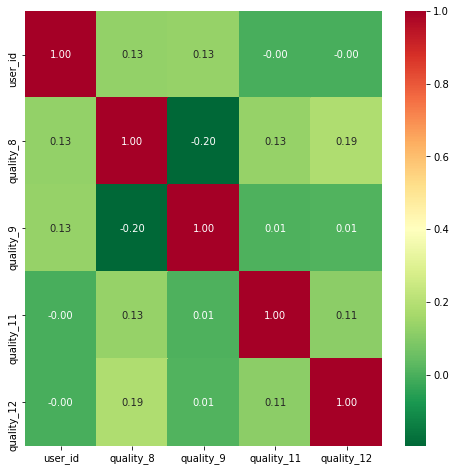

In [43]:
plt.figure(figsize=(8,8))
sns.heatmap(train_qua_1.corr(), annot=True, fmt='.2f', cmap='RdYlGn_r')

<AxesSubplot:>

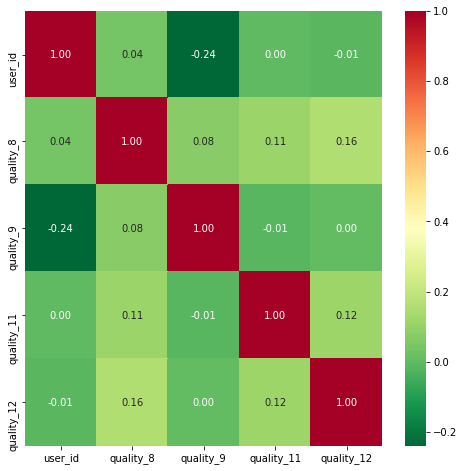

In [44]:
plt.figure(figsize=(8,8))
sns.heatmap(test_qua_1.corr(), annot=True, fmt='.2f', cmap='RdYlGn_r')

In [22]:
train = train.merge(train_qua_1, on='user_id', how='left').fillna(0)
test = test.merge(test_qua_1, on='user_id', how='left').fillna(0)

In [23]:
train_prob1 = train_prob.groupby('user_id').count().reset_index()
train_prob1.time = train_prob1.time.apply(chg_qua)
train_prob1.columns = ['user_id', 'prob']
train_prob1

,user_id,prob
0,10001,1
1,10004,1
2,10005,1
3,10006,1
4,10008,1
...,...,...
4995,24983,1
4996,24984,1
4997,24990,1
4998,24997,1


In [24]:
train = train.merge(train_prob1, on='user_id', how='left').fillna(0)

In [ ]:
display(train.head())
display(test.head())

In [47]:
train.shape, test.shape

((15000, 11), (14998, 10))

<AxesSubplot:>

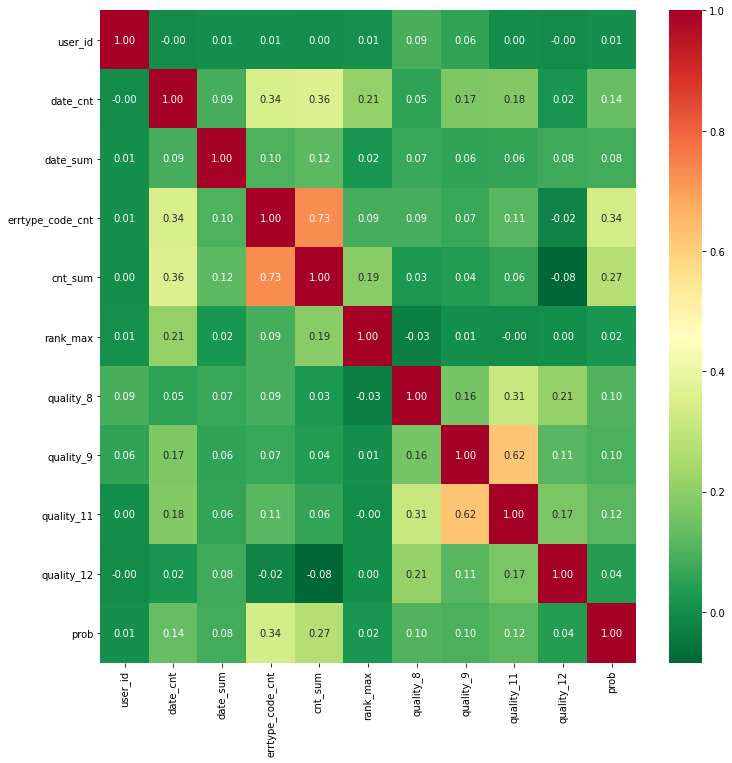

In [46]:
plt.figure(figsize=(12,12))
sns.heatmap(train.corr(), annot=True, fmt='.2f', cmap='RdYlGn_r')

In [ ]:
test.columns

In [ ]:
cols = ['date_cnt', 'date_sum', 'model_fwver_cnt', 'model_fwver_max','errtype_code_max']

In [ ]:
min = train[cols].min()
max  = train[cols].max()

In [ ]:
for i, col in enumerate(cols):
    train[col] = (train[col] - min[i]) / (max[i] - min[i])
    test[col] = (test[col] - min[i]) / (max[i] - min[i])

In [48]:
train.prob = train.prob.astype(int)

In [49]:
%%time
clf = setup(session_id=42, data=train, target='prob')

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(15000, 11)"
4,Missing Values,False
5,Numeric Features,6
6,Categorical Features,4
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 38.8 s


In [50]:
best = compare_models(sort = 'AUC', n_select = 5
                     ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                     )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.7408,0.7572,0.4103,0.6858,0.5132,0.3516,0.3732,5.6304
1,Gradient Boosting Classifier,0.7401,0.7557,0.3837,0.7005,0.4955,0.3403,0.3683,0.7992
2,Light Gradient Boosting Machine,0.7375,0.7489,0.4077,0.6760,0.5084,0.3442,0.3647,0.2045
3,Ada Boost Classifier,0.7313,0.7467,0.3949,0.6618,0.4940,0.3271,0.3474,0.2523
4,Extreme Gradient Boosting,0.7314,0.7383,0.4300,0.6457,0.5158,0.3404,0.3540,0.5403
5,Linear Discriminant Analysis,0.7252,0.7142,0.3166,0.6912,0.4337,0.2845,0.3223,0.0423
6,Extra Trees Classifier,0.6909,0.6952,0.4297,0.5456,0.4803,0.2651,0.2690,0.3094
7,Random Forest Classifier,0.7008,0.6878,0.3923,0.5748,0.4660,0.2686,0.2781,0.1193


In [51]:
blended = blend_models(estimator_list = best, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7300,0.7443,0.3986,0.6565,0.4960,0.3263,0.3453
1,0.7619,0.7774,0.4457,0.7358,0.5552,0.4057,0.4295
2,0.7381,0.7538,0.3957,0.6856,0.5018,0.3411,0.3648
3,0.7429,0.7577,0.3943,0.7041,0.5055,0.3499,0.3768
4,0.7265,0.7385,0.3871,0.6514,0.4857,0.3155,0.3353
Mean,0.7399,0.7543,0.4043,0.6867,0.5088,0.3477,0.3703
SD,0.0124,0.0134,0.0211,0.0312,0.0241,0.0313,0.0329


In [52]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7412,0.7557,0.3993,0.6941,0.507,0.3484,0.3728


In [53]:
%%time
final_model = finalize_model(blended)

Wall time: 1min 42s


In [54]:
test_x = sample_submssion[['user_id']].merge(test, on='user_id', how='left').fillna(0)
test_x.shape

(14999, 10)

In [55]:
predictions = predict_model(final_model, data = test_x)

In [56]:
sample_submssion['problem'] = predictions['Score']
sample_submssion.head()

,user_id,problem
0,30000,0.8350
1,30001,0.3696
2,30002,0.5042
3,30003,0.5981
4,30004,0.6914


In [57]:
sample_submssion.to_csv("./submission/submission_20210126-5.csv", index = False)
sample_submssion

,user_id,problem
0,30000,0.8350
1,30001,0.3696
2,30002,0.5042
3,30003,0.5981
4,30004,0.6914
...,...,...
14994,44994,0.3819
14995,44995,0.4003
14996,44996,0.6129
14997,44997,0.6918
